In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

Part 1: Outline 
1. Brief data set descriptions
    Where is data coming from ?
    quantity, resolution(time, space) ?
    source, format ?

Data is coming from three sites:    
nino3.4 1948 dataset - http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_1948

air temperature     - http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_CONUS/ 

precipitation       -  http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_CONUS/

N34 data: 
Grid Time[(Jan 1948)... (Nov 2020)] N= 875 pts :grid
doublearraytype
iridl:SeaSurfaceTemperature
pointwidth: 1.0
standard_name: sea_surface_temperature
units: Celsius_scale
standard units*degree_Kelvin above 273.15
history: Averaged over X[171W, 119W] Y[5S, 5N] minimum 0.0% data present

Air temp data:
Time[ (Jan 1948) ... (Oct 2020)] N= 874 pts :grid
Longitude (longitude)
grid: /X (degree_east) ordered (130.25W) to (54.75W) by 0.5 N= 152 pts :grid
Latitude (latitude)
grid: /Y (degree_north) ordered (19.75N) to (50.25N) by 0.5 N= 62 pts :grid 
        
Precipitation:
Time [ (Jan 1948) ... (Oct 2020)] N= 874 pts :grid
Longitude (longitude)
grid: /X (degree_east) ordered (130.125W) to (54.875W) by 0.25 N= 302 pts :grid
Latitude (latitude)
grid: /Y (degree_north) ordered (20.125N) to (49.875N) by 0.25 N= 120 pts :grid
units: mm /day
standard units*1.15740740740741×10-08 meter second-1
history: home tippett scratch APMA4990 prcp_CONUS
T: 1200 31 Dec 2006 - 1200 1 Jan 2007 to 1200 27 Nov 2020 - 1200 28 Nov 2020 appended from NOAA NCEP CPC UNIFIED_PRCP GAUGE_BASED CONUS v1p0 REALTIME rain


2. Scientific question and what calculations will address them ?

Compute the difference between El Nino and La Nina temperature (also precipitation) and use the t-test to test statistical significance.

https://www.cpc.ncep.noaa.gov/products/precip/CWlink/ENSO/composites/EC_ENP_index.shtml shows composites (conditional means) but there is no test of statistical significance.

First will -compute anomalies in the usual xarray way with groupby(’T.month’).mean(). Use “sel()” to use the period 1981-2010 as the climatological period. 

Then -classify months as La Nina or El Nino using the threshold of +/- 0.5 degrees.  
Thirdly -compute the La Nina and El Nino averages for precipitation. 
Finally - there will be 12 maps one for each month. The “groupby” will do a lot without loops. Also xarray faceting http://xarray.pydata.org/en/stable/plotting.html#plotting-faceting

In [2]:
nino_url="http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_1948/dods"
n34ds = xr.open_dataset(nino_url)
n34ds

<xarray.Dataset>
Dimensions:   (T: 875)
Coordinates:
  * T         (T) datetime64[ns] 1948-01-16T12:00:00 ... 2020-11-16
Data variables:
    n34_1948  (T) float64 ...
Attributes:
    Conventions:  IRIDL

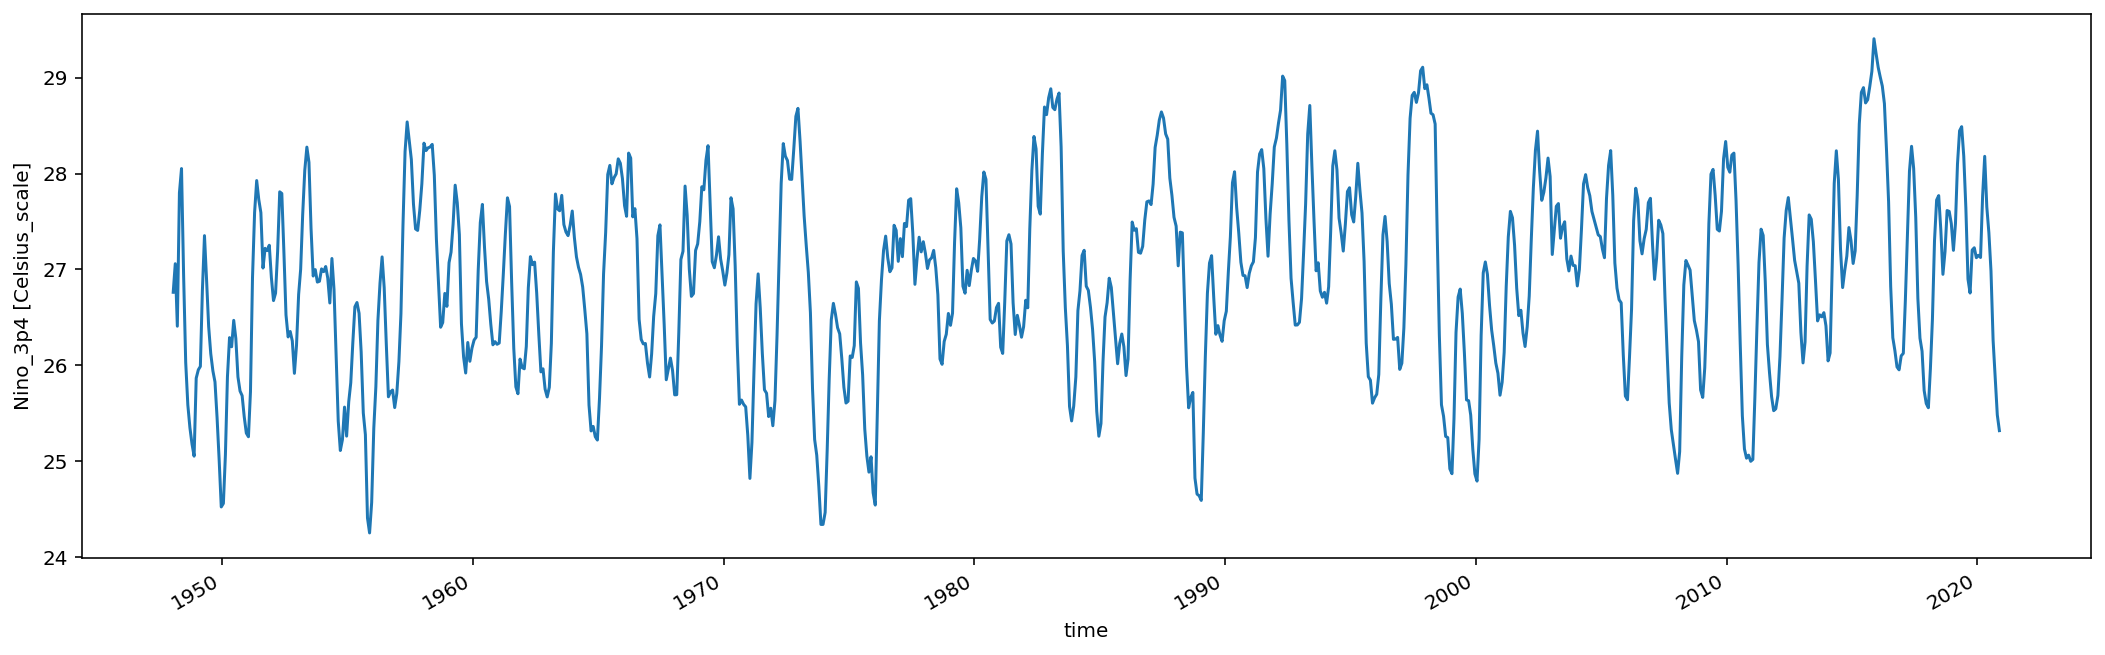

In [3]:
fig, ax = plt.subplots(figsize=(18,5))
n34ds.n34_1948.plot();

n34 data from 1948 - 2020 where x- axis is in Celsius degrees. 

In [4]:
#climatology = n34.groupby("T.month").mean()
#climatology = n34_ds.n34_1948.sel(T=slice('1981','2010')).groupby("T.month").mean('T')
climatology = n34ds.n34_1948.groupby("T.month").mean('T')
anomaly = n34ds.n34_1948.groupby("T.month") - climatology

In [5]:
import numpy as np
from datetime import datetime
months =[datetime(2010, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
month_str

['Jan',
 'Feb',
 'Mar',
 'Apr',
 'May',
 'Jun',
 'Jul',
 'Aug',
 'Sep',
 'Oct',
 'Nov',
 'Dec']

In [6]:
# Use a comprehension list (one line) to make a list with the first letter of the month
month_str[0]
m_str=[z[0] for z in month_str]
print(m_str)

['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']


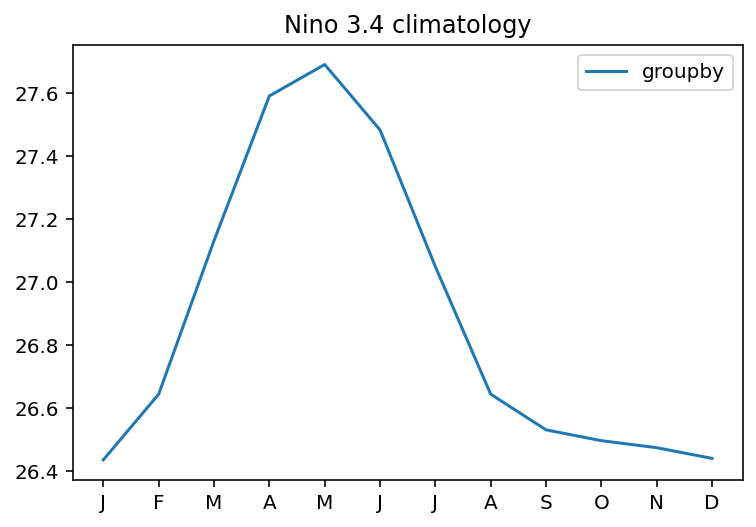

In [7]:
# plot them
plt.plot(climatology, label = 'groupby')
plt.legend()
plt.xticks(np.arange(0,12), m_str)
plt.title('Nino 3.4 climatology');

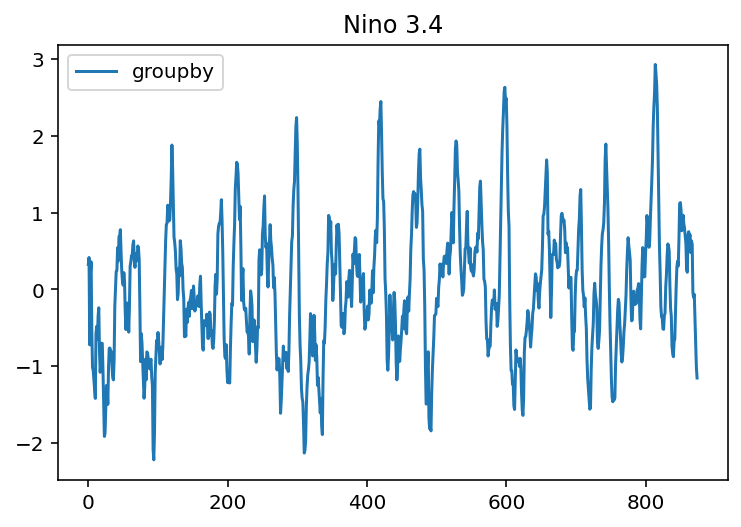

In [8]:
# plot them
plt.plot(anomaly, label = 'groupby')
plt.legend()
plt.title('Nino 3.4');

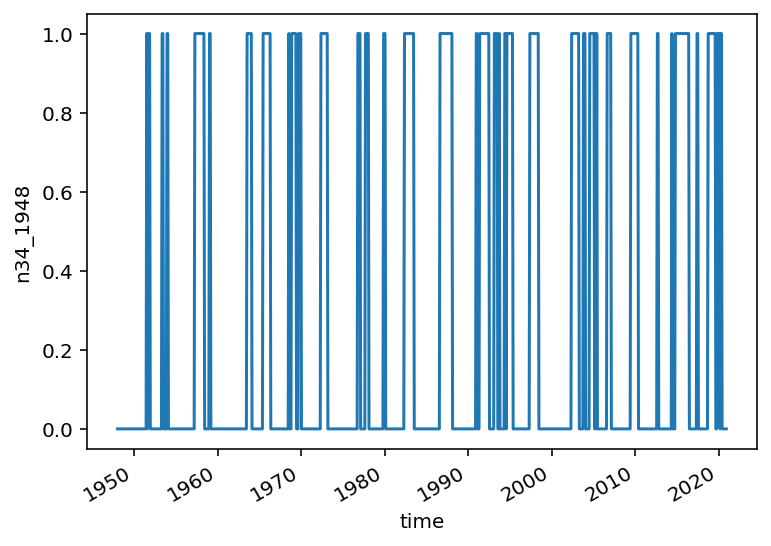

In [9]:
#plotting should be from orignal 1948 - present
(anomaly >0.5).plot()

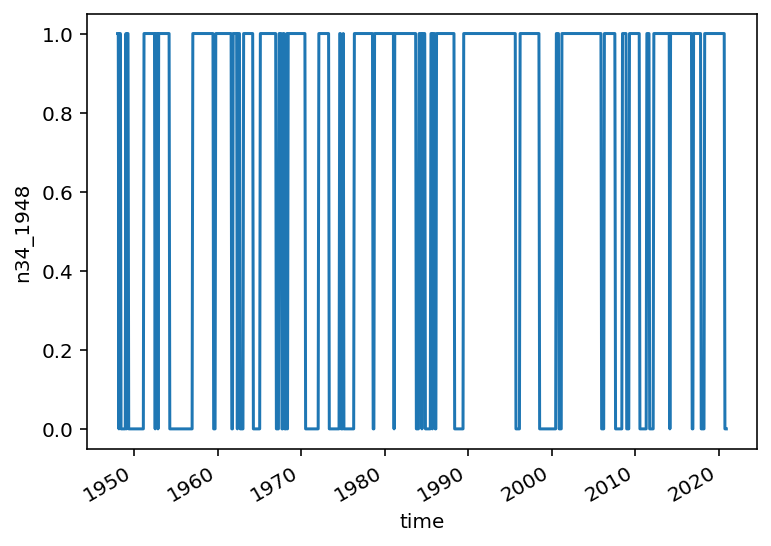

In [10]:
(anomaly >-0.5).plot()

In [11]:
# Define warm and cool ENSO categories

t_nina = anomaly <= [-0.5]
t_nino = anomaly >= [0.5]
t_neut = ~(t_nina | t_nino)
t_nina 

<xarray.DataArray 'n34_1948' (T: 875)>
array([False, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True, False, False, False,  True,  True,  True,  True,
...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True])
Coordinates:
  * T        (T) datetime64[ns] 1948-01-16T12:00:00 ... 2020-11-16
    month    (T) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10 11

In [12]:
anomaly[t_nina]

<xarray.DataArray 'n34_1948' (T: 260)>
array([-0.72320112, -0.54326096, -1.01811478, -1.05603638, -1.1815078 ,
       -1.31658769, -1.42026878, -0.57286986, -0.65451484, -0.79999547,
       -1.07967524, -0.9273987 , -0.7007847 , -0.70296356, -1.04227889,
       -1.46210316, -1.91570173, -1.8744395 , -1.5742802 , -1.25188918,
       -1.30223436, -1.49781594, -1.01424548, -0.76714906, -0.76378481,
       -0.79757859, -0.81172846, -1.00927651, -1.14592976, -1.1792181 ,
       -0.91797308, -0.52296964, -0.55658483, -0.94110649, -0.57713201,
       -0.69361727, -0.94436066, -1.22414215, -1.41805671, -1.27045074,
       -0.90864458, -1.17751126, -0.81416479, -0.82498163, -0.90052434,
       -0.98093268, -1.0363475 , -0.94045625, -0.90922143, -1.13977164,
       -1.25279576, -2.08697929, -2.22086568, -1.86948009, -1.09031379,
       -0.86774815, -0.66348165, -0.73347567, -0.56063201, -0.67411492,
       -0.82483696, -0.97127617, -0.80631788, -0.75297087, -0.91366351,
       -0.73315688, -0.61696346, -0.55572689, -0.60998757, -0.75428572,
       -0.79169539, -0.64126947, -0.5978833 , -0.53193529, -0.72128475,
       -0.76869121, -0.66274129, -0.64313233, -0.87470505, -0.90205891,
       -0.72002646, -1.05780863, -1.21403359, -1.13262169, -1.21753096,
       -1.21823923, -0.77708682, -0.55613184, -0.52355954, -0.62058688,
       -0.84259296, -0.68029358, -0.52981627, -0.74249439, -0.94933061,
       -0.79015557, -0.50241048, -0.84313767, -1.04943081, -0.89178575,
...
       -0.6058334 , -0.62693304, -0.93782678, -0.78257695, -0.67124746,
       -0.51325377, -0.54131876, -0.57749684, -1.00610239, -1.49265505,
       -1.49169168, -0.97777047, -0.81237558, -1.67068477, -1.8156389 ,
       -1.79895144, -1.84326914, -1.35046097, -1.04473842, -0.83846214,
       -0.62457703, -0.64807073, -0.65077573, -0.86769066, -0.77771225,
       -0.73580389, -0.73788725, -0.73136886, -1.0546514 , -1.06075083,
       -1.23616644, -1.22664111, -1.5181702 , -1.56460534, -1.19922204,
       -0.78855124, -0.87886423, -0.8960797 , -0.94093646, -0.91963477,
       -1.00383204, -0.89874141, -1.01395206, -1.34766052, -1.57129072,
       -1.64176032, -1.41721776, -0.82011113, -0.62711586, -0.61320581,
       -0.53450627, -0.55531647, -0.75078658, -0.61117977, -0.50767294,
       -0.75915973, -0.79342259, -0.55266816, -0.54718085, -0.50848247,
       -0.92229558, -1.16607428, -1.30031929, -1.41620429, -1.56097601,
       -1.54305696, -1.04364162, -0.75378575, -0.59820626, -0.69562764,
       -0.76898441, -0.6692954 , -0.53190844, -0.82306579, -1.16856247,
       -1.40182821, -1.46399656, -1.40963153, -1.43995953, -1.41582145,
       -0.97922343, -0.74736155, -0.51912613, -0.60527477, -0.82192961,
       -0.94605232, -0.89254743, -0.74862236, -0.55236347, -0.51401343,
       -0.51240425, -0.52016298, -0.7356878 , -0.83749554, -0.87659116,
       -0.6775535 , -0.65088204, -0.65351012, -1.01220484, -1.15423366])
Coordinates:
  * T        (T) datetime64[ns] 1948-03-16T12:00:00 1948-06-16 ... 2020-11-16
    month    (T) int64 3 6 7 8 9 10 11 12 2 5 6 ... 2 10 11 11 12 1 2 3 9 10 11

In [13]:
anomaly[t_nino]

<xarray.DataArray 'n34_1948' (T: 236)>
array([0.54385831, 0.69043593, 0.7009008 , 0.77902805, 0.58428809,
       0.63322203, 0.56672074, 0.54255493, 0.63808519, 0.84693665,
       0.86222653, 1.09827184, 1.03782401, 0.89245186, 0.91148293,
       1.14221081, 1.45282056, 1.88223063, 1.59599022, 1.13670461,
       0.68539788, 0.61256517, 0.63589651, 0.53754111, 0.72377023,
       0.82474726, 0.86024701, 0.85741972, 0.98794215, 1.169925  ,
       0.89781823, 0.60138919, 0.84433991, 1.31408305, 1.46661063,
       1.65759995, 1.63423513, 1.50841044, 1.23027227, 0.91108548,
       1.0819283 , 0.56994178, 0.51697279, 0.72457214, 0.82720814,
       1.0642175 , 1.21912466, 0.6992515 , 0.54681723, 0.59922491,
       0.61921463, 0.84477842, 0.63586305, 0.54499117, 0.62099663,
       0.69736972, 1.08698013, 1.29770723, 1.40929542, 1.75956571,
       2.12345732, 2.24053626, 1.89924807, 1.30713845, 0.96503031,
       0.93435714, 0.64519706, 0.88677097, 0.58322876, 0.84059561,
       0.71014579, 0.85001165, 0.73139397, 0.51926061, 0.67535792,
       0.65385812, 0.69508979, 0.77320727, 0.60982286, 0.93350621,
       1.67518814, 2.19827608, 2.14097055, 2.35096851, 2.44926657,
       2.04546689, 1.53448871, 1.183266  , 1.14837005, 0.79394622,
       0.52632043, 0.71062398, 1.01965796, 1.23195997, 1.27557967,
       1.24201281, 1.24687624, 1.14140698, 0.80903935, 0.86735991,
...
       0.51584638, 0.8846936 , 1.33143139, 1.79828537, 2.09864462,
       2.31252484, 2.57608388, 2.63528928, 2.44650594, 2.49115482,
       2.14373345, 1.49789592, 1.02198399, 0.82545918, 0.55273447,
       0.95877286, 0.98119343, 1.07751494, 1.27556555, 1.46124755,
       1.68841343, 1.52955203, 0.72133423, 0.75971241, 0.52678789,
       0.64397133, 0.56894521, 0.59970909, 0.7200291 , 0.96110906,
       0.99283932, 0.94392323, 0.88757236, 0.90368962, 0.77619505,
       0.6082907 , 0.54800657, 0.51919156, 0.79004866, 0.92234742,
       1.2229848 , 1.30246528, 0.8192827 , 0.55978643, 0.72598431,
       0.77539759, 0.87046629, 1.11052481, 1.68107097, 1.89496165,
       1.6303724 , 1.37088567, 1.06135922, 0.62208414, 0.67458265,
       0.56563235, 0.54583647, 0.64371164, 0.96371893, 0.86063058,
       0.62770668, 0.54995391, 0.64027582, 0.9264401 , 1.15531942,
       1.41255678, 1.68790147, 2.1267304 , 2.37913692, 2.57037584,
       2.93245183, 2.8133732 , 2.67215537, 2.36244986, 1.78044283,
       1.13823264, 0.55387527, 0.59270822, 0.57071209, 0.65563886,
       1.11890469, 1.13220329, 1.03917043, 0.76458832, 0.83354524,
       0.96726531, 0.85495323, 0.7973211 , 0.69669373, 0.59417833,
       0.70644266, 0.75295096, 0.68306864, 0.71285816, 0.63386883,
       0.58821147])
Coordinates:
  * T        (T) datetime64[ns] 1951-07-16T12:00:00 1951-09-16 ... 2020-04-16
    month    (T) int64 7 9 10 11 5 6 12 1 4 5 6 7 ... 2 3 4 5 6 7 10 11 12 1 3 4

air temp t2m data; x- axis in longitude (degree east) and y -axis is latitude (degree north) for la nina data 

# Main tasks
1. For 2m-temperature (t2m) and precipitation compute for each month of the year
    - The La Nina and El Nino composites (conditional means conditional on being La Nina or El Nino)
    - The difference of the The Nina and El Nino composites. Use the t-test to say where the difference is statistically significant.
    - The linear trend (a map of the regression coefficients of the data with time) and whether they are statistically significant 

# Read Nino 3.4

(874,)


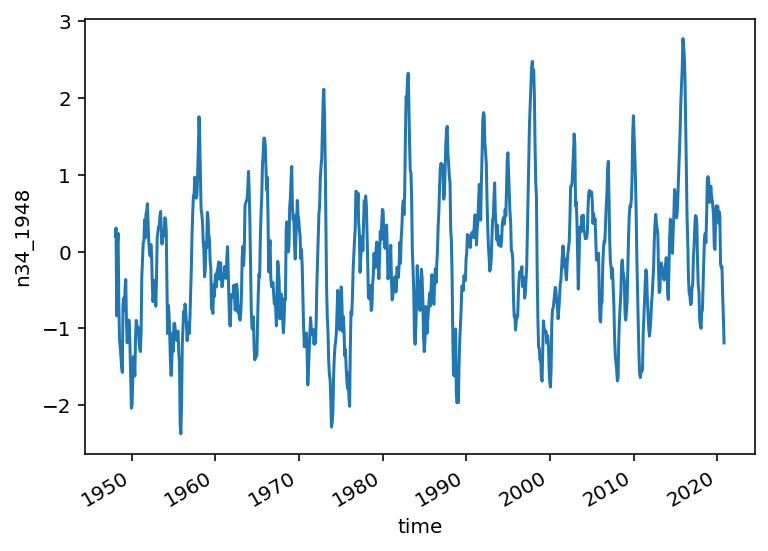

In [14]:
nino_url="http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_1948/dods"
n34_ds = xr.open_dataset(nino_url)
n34 = n34_ds.n34_1948
n34a = n34.groupby('T.month') - n34.sel(T = slice('1981', '2010')).groupby('T.month').mean('T')
#
n34a = n34a.sel(T = slice('1948-01', '2020-10'))
print(n34a.shape)
n34a.plot();

# Read temperature data

In [15]:
# read and plot last value
t2m_url="http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_CONUS/dods"
t2m_ds = xr.open_dataset(t2m_url)
t2m = t2m_ds.t2m_CONUS
t2ma = t2m.groupby('T.month') - t2m.sel(T = slice('1981', '2010')).groupby('T.month').mean('T')

/opt/conda/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(874, 62, 152)


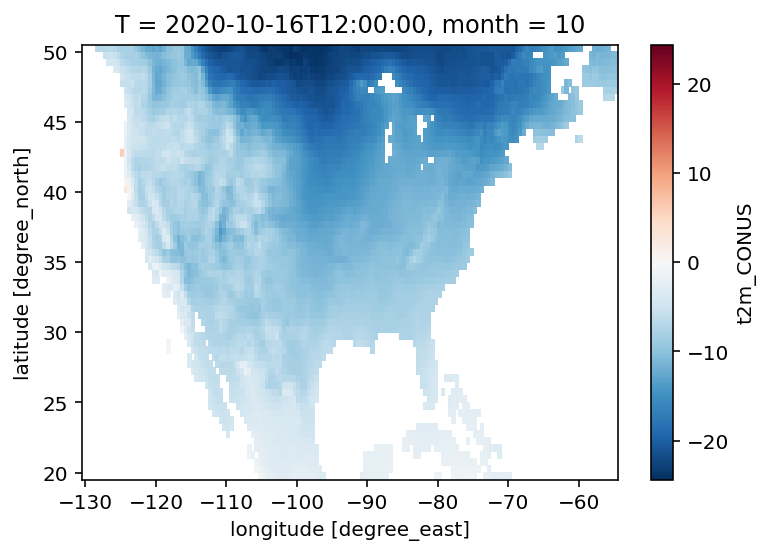

In [16]:
t2ma = t2ma.sel(T = slice('1948-01', '2020-10'))
print(t2ma.shape)
t2ma.isel(T=-1).plot();

## La Nina mean

/opt/conda/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


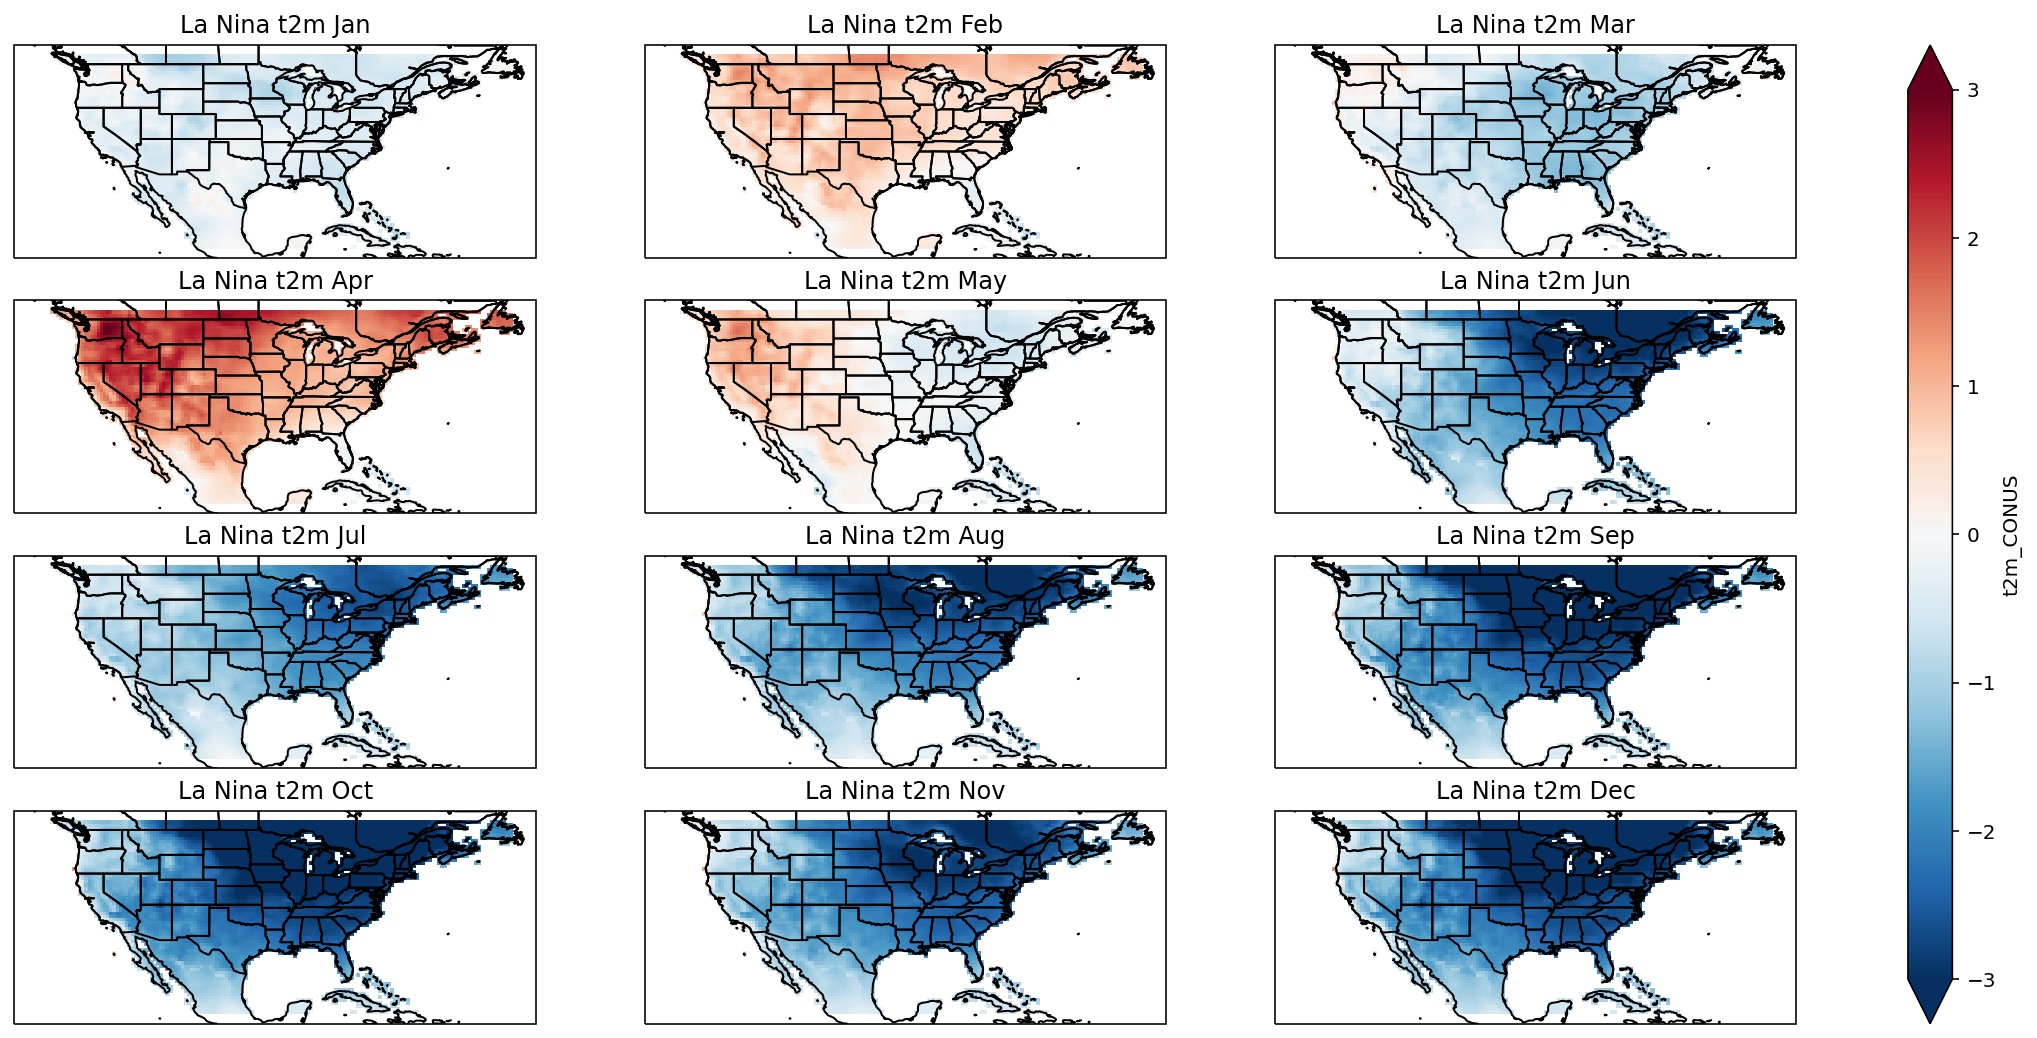

In [17]:
proj = ccrs.PlateCarree()
g = t2ma.isel(T = (n34a < -0.5)).groupby('T.month').mean('T').plot(x = 'X', y = 'Y', transform=proj, subplot_kws={'projection':proj},
                                                               vmin = -3, vmax = 3, cmap = 'RdBu_r', figsize = (20, 9),
                                                               col='month', col_wrap=3);
for ii, ax in enumerate(g.axes.flat):
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    ax.set_title('La Nina ' + 't2m ' + month_str[ii])

## El Nino mean

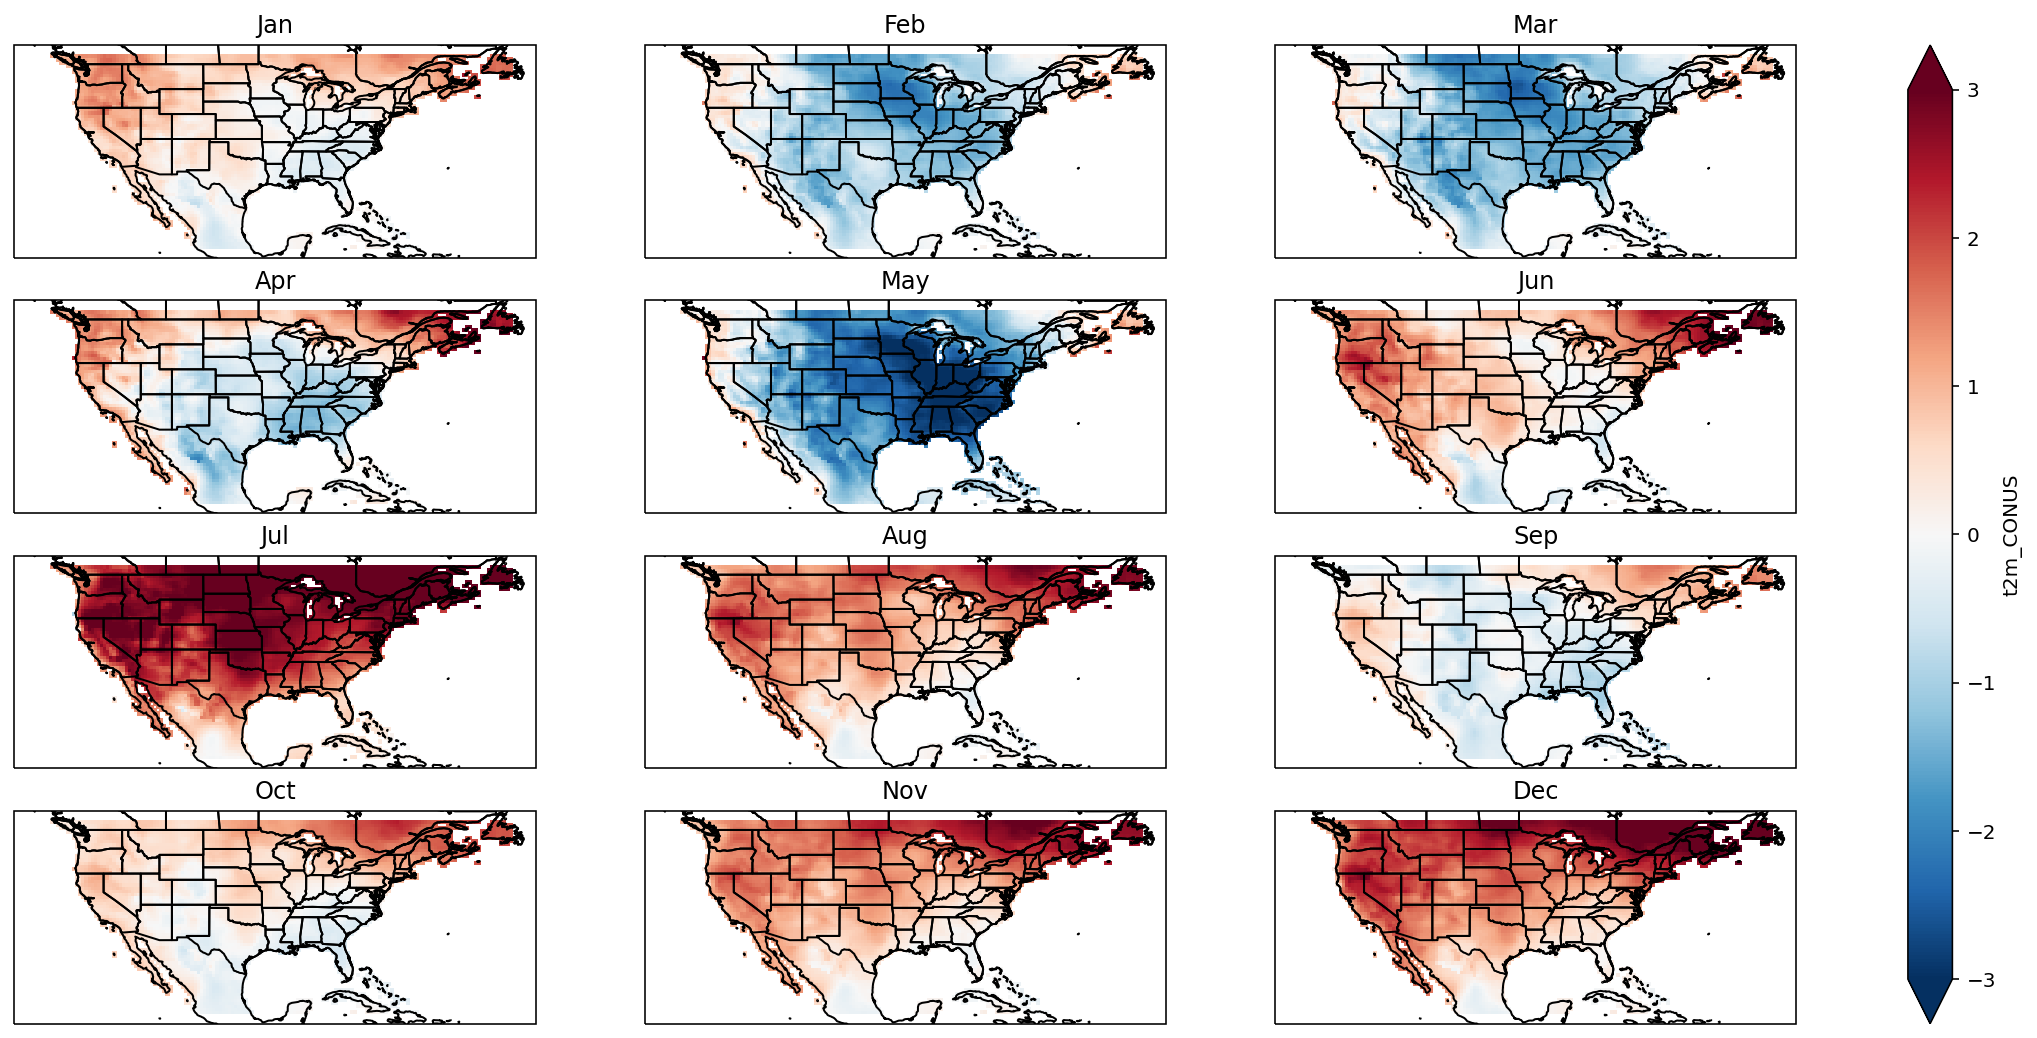

In [18]:
proj = ccrs.PlateCarree()
g = t2ma.isel(T = (n34a > 0.5)).groupby('T.month').mean('T').plot(x = 'X', y = 'Y', transform=proj, subplot_kws={'projection':proj},
                                                               vmin = -3, vmax = 3, cmap = 'RdBu_r', figsize = (20, 9),
                                                               col='month', col_wrap=3);
for ii, ax in enumerate(g.axes.flat):
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    ax.set_title(month_str[ii])

In [19]:
n34_1 = n34a- n34a.mean()
t_nina_1 = n34_1.values <= -0.5
t_nino_1 = n34_1.values >= 0.5

np.quantile(n34_1,np.array([0.25, 0.75]))

array([-0.62262567,  0.55949221])

T- TEST 
The difference of the The Nina and El Nino composites. Use the t-test to say where the difference is statistically significant.

In [20]:
# T-test for difference in means
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)
df = Nx + Ny - 2

X = t2ma.isel(T = (n34a < -0.5)).groupby('T.month').mean('T')
Y = t2ma.isel(T = (n34a > 0.5)).groupby('T.month').mean('T')

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
t2ma_t = (X - Y)/np.sqrt(pooled_var)/np.sqrt(1./Nx + 1./Ny)
t2ma_p = 2*(1-stats.t.cdf(np.abs(t2ma_t), df=df))

print([t2ma_t,t2ma_p])
print(stats.ttest_ind(X, Y))

[<xarray.DataArray 't2m_CONUS' (month: 12, Y: 62, X: 152)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ..., -14.12841843,
         -14.75881502, -14.63416477],
        [         nan,          nan,          nan, ..., -14.94282108,
         -15.23191757, -15.13275693],
        [         nan,          nan,          nan, ..., -15.54703303,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,       

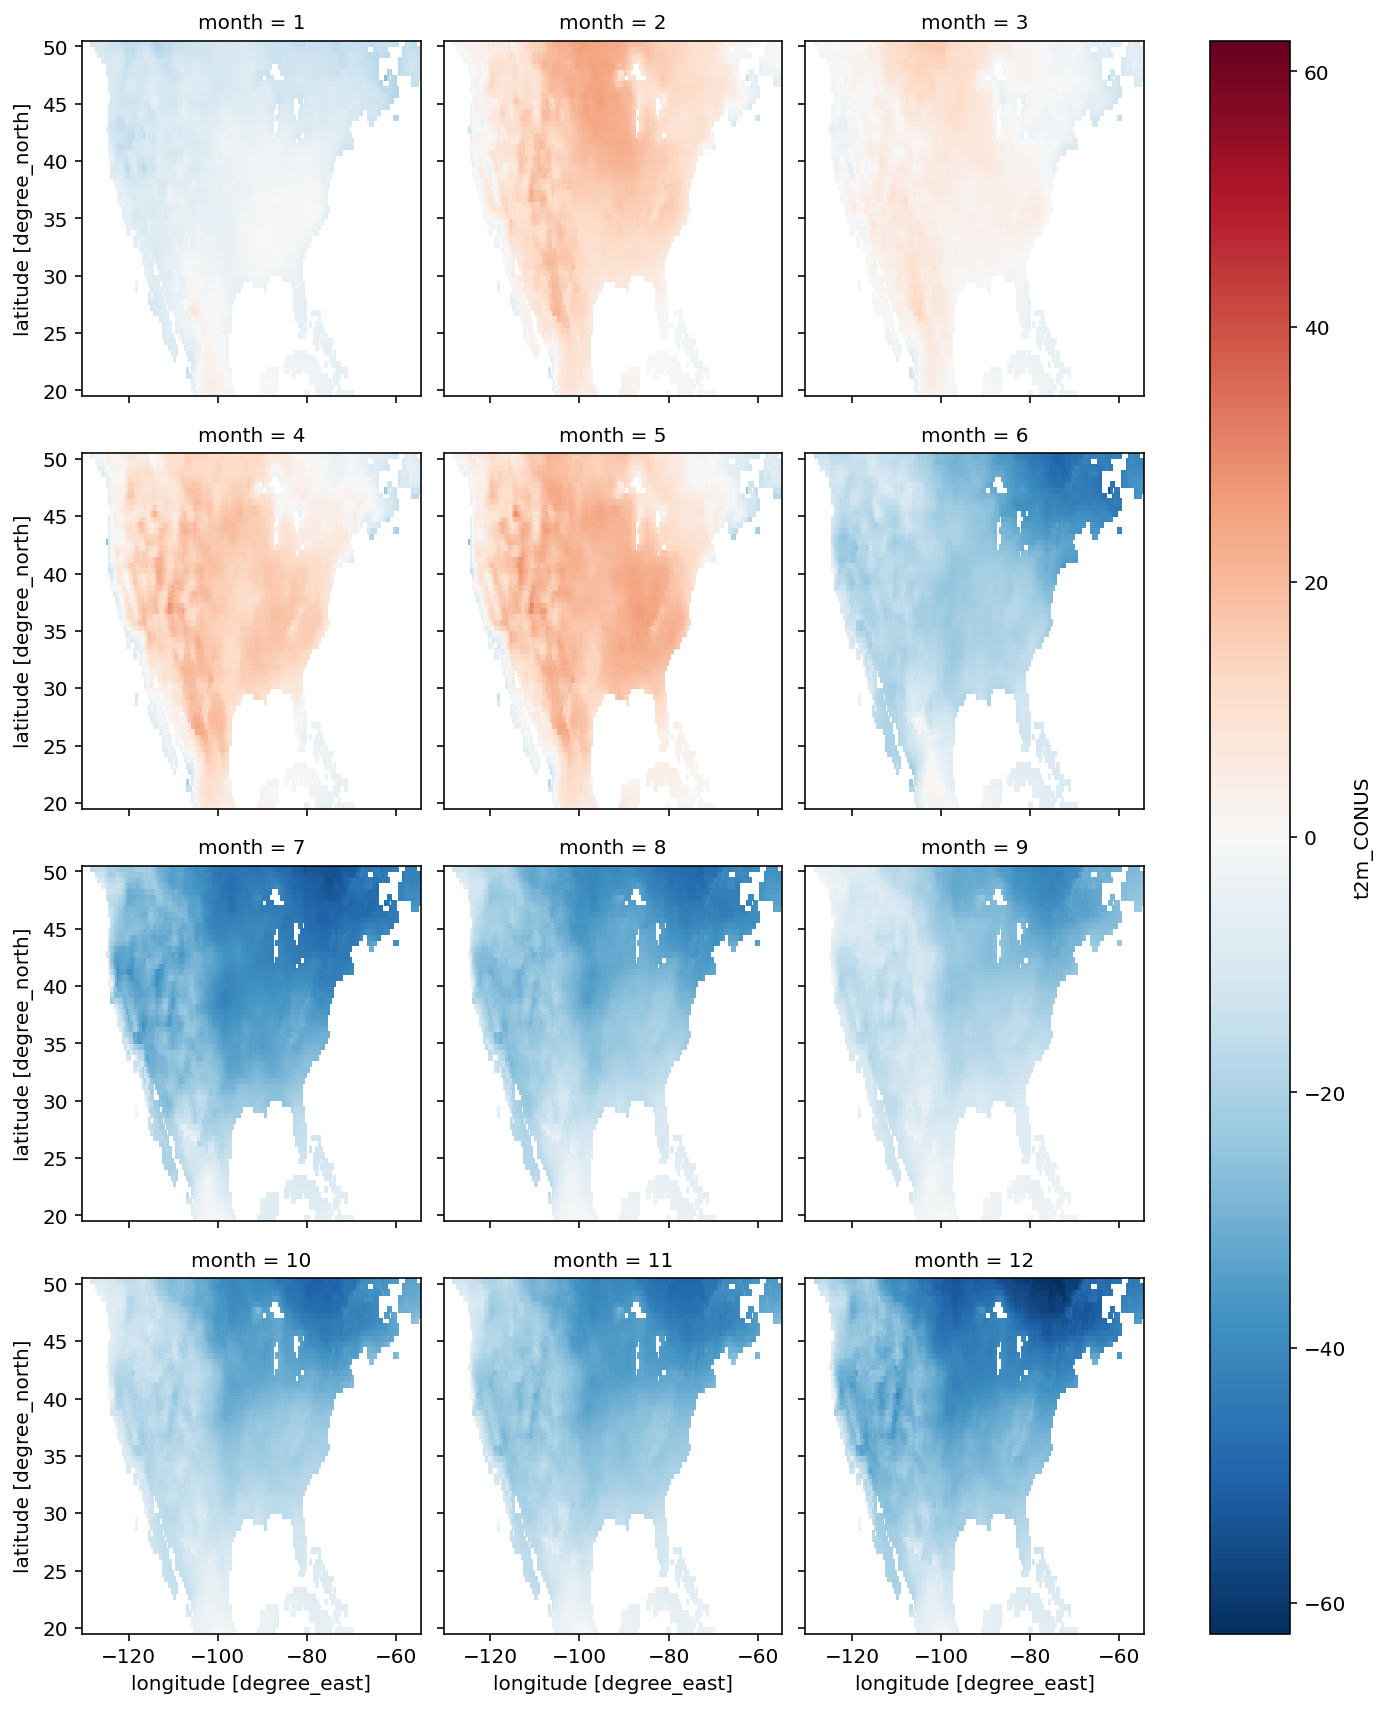

In [39]:
t2ma_t.plot(col='month',col_wrap=3)

In [67]:
X.shape

(12, 62, 152)

In [65]:
t2ma_p.shape

(12, 62, 152)

<ipython-input-74-bcd0d18815f1>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask = np.zeros(dta.shape) ; mask[(np.abs(dta)<sig_value) | np.isnan(dta)] = np.nan


IndexError: too many indices for array: array is 3-dimensional, but 24 were indexed

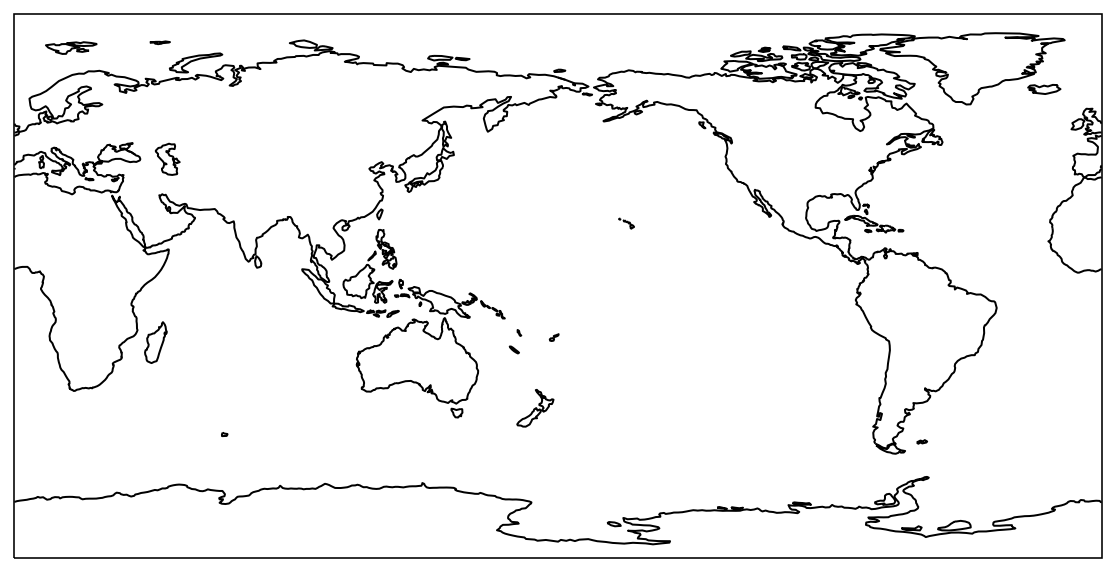

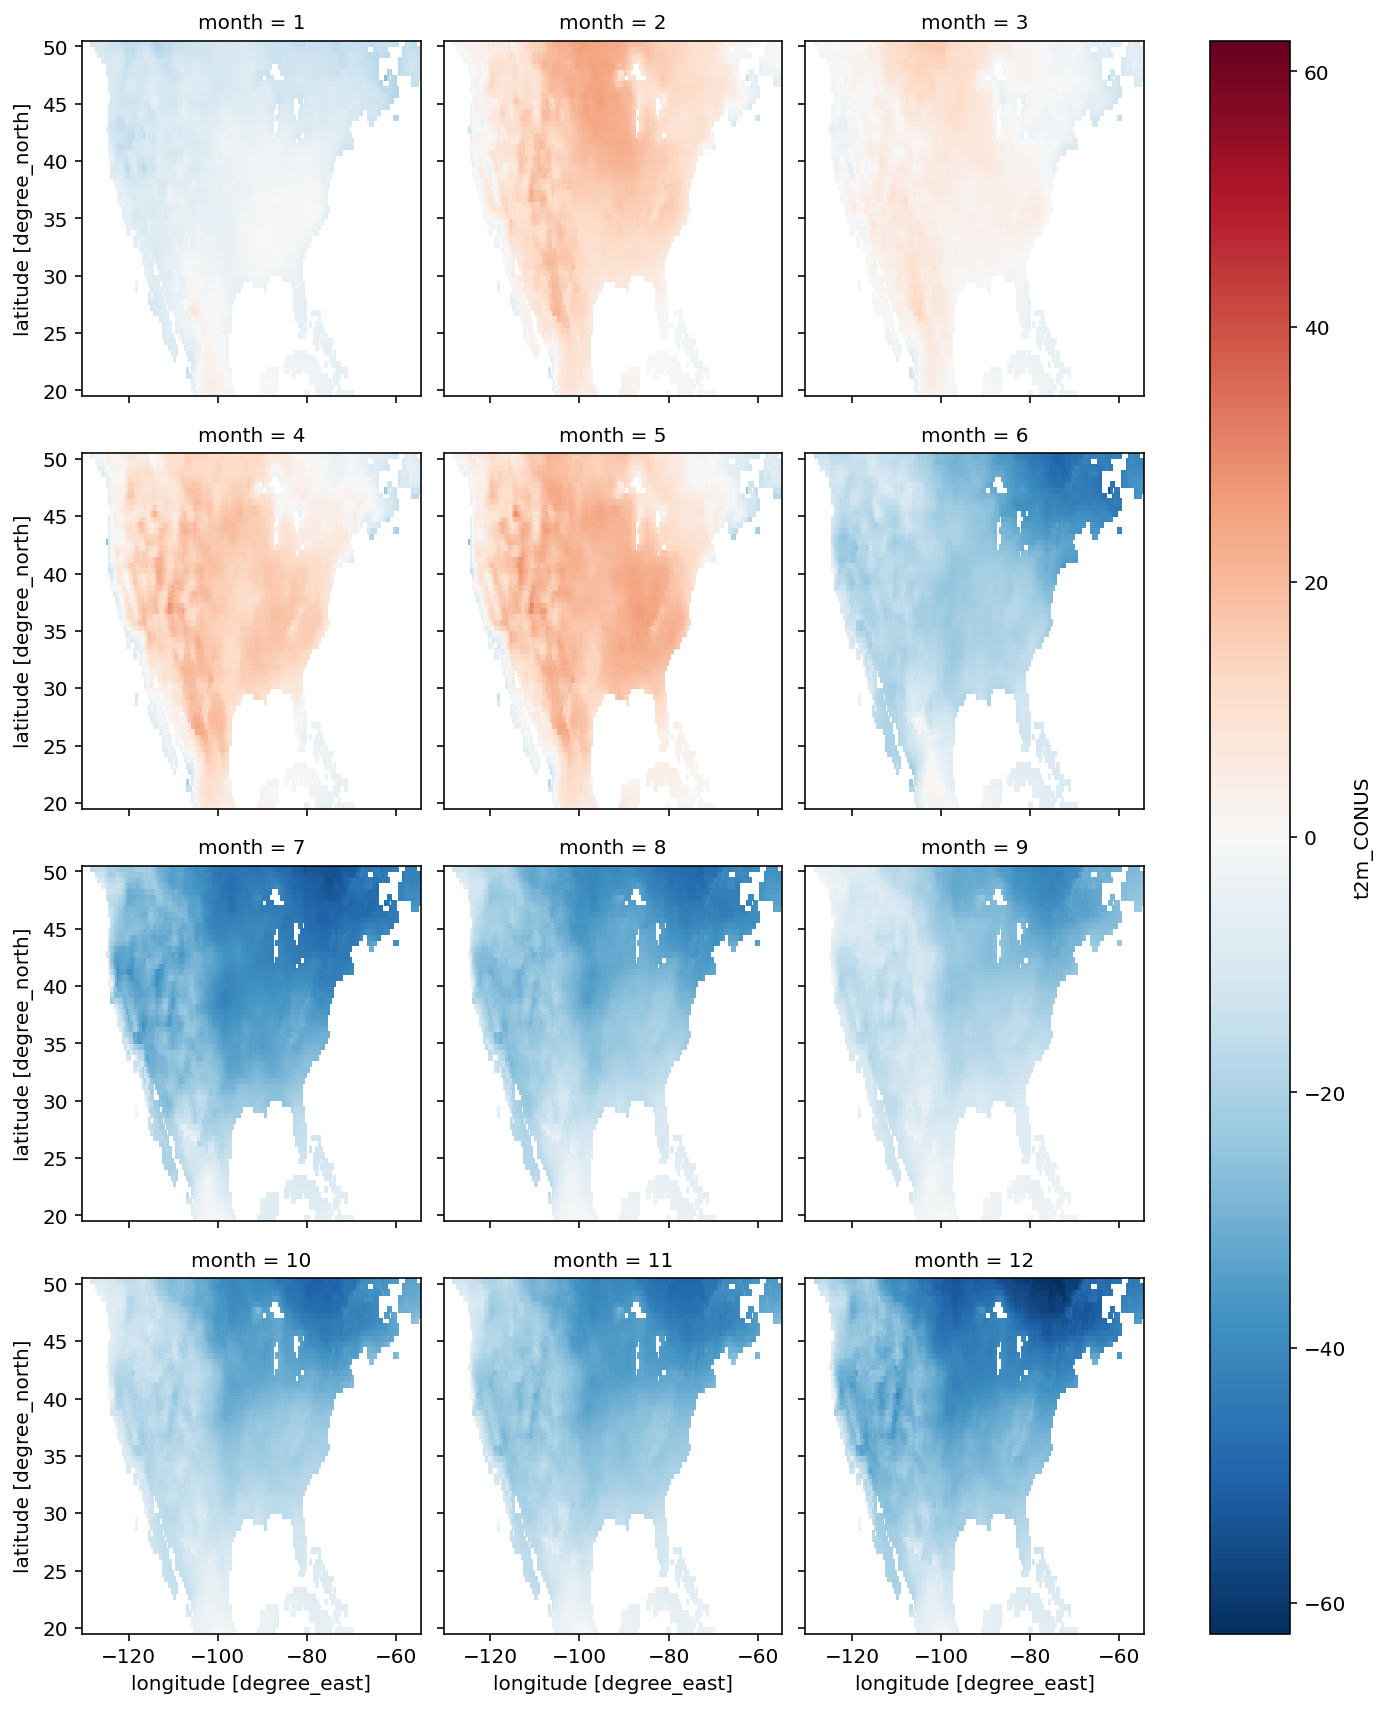

In [74]:
proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

N = len(n34)

t2ma_t.plot(col='month',col_wrap=3)
ax.coastlines();
dta = t2ma_t
lon = dta.X
lat = dta.Y
sig_value = 0.05
mask = np.zeros(dta.shape) ; mask[(np.abs(dta)<sig_value) | np.isnan(dta)] = np.nan
plt.contourf(lon, lat, mask, hatches=['.'], colors='none', transform=proj_dta);

In [41]:
pvalue.shape

NameError: name 'pvalue' is not defined

In [40]:
plt.pcolormesh(pvalue<0.05)

NameError: name 'pvalue' is not defined

# Read Percipitation data

In [ ]:
# read and plot last value
prcp_url="http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_CONUS/dods"
prcp_ds = xr.open_dataset(prcp_url)
prcp = prcp_ds.prcp_CONUS
prcpa = prcp.groupby('T.month') - prcp.sel(T = slice('1981', '2010')).groupby('T.month').mean('T')

In [ ]:
print(prcp.shape)

In [ ]:
prcpa = prcpa.sel(T = slice('1948-01', '2020-10'))
print(prcpa.shape)
prcpa.isel(T=-1).plot();

La Nina mean 

In [ ]:
proj = ccrs.PlateCarree()
g = prcpa.isel(T = (n34a < -0.5)).groupby('T.month').mean('T').plot(x = 'X', y = 'Y', transform=proj, subplot_kws={'projection':proj},
                                                               vmin = -3, vmax = 3, cmap = 'RdBu_r', figsize = (20, 9),
                                                               col='month', col_wrap=3);
for ii, ax in enumerate(g.axes.flat):
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    ax.set_title('La Nina ' + 'prcp ' + month_str[ii])

El Nino mean 

In [ ]:
proj = ccrs.PlateCarree()
g = prcpa.isel(T = (n34a > 0.5)).groupby('T.month').mean('T').plot(x = 'X', y = 'Y', transform=proj, subplot_kws={'projection':proj},
                                                               vmin = -3, vmax = 3, cmap = 'RdBu_r', figsize = (20, 9),
                                                               col='month', col_wrap=3);
for ii, ax in enumerate(g.axes.flat):
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    ax.set_title(month_str[ii])

In [ ]:
# T-test for difference in means
Nx = np.count_nonzero(t_nina)
Ny = np.count_nonzero(t_nino)
df = Nx + Ny - 2

X = prcp[t_nina].values
Y = prcp[t_nino].values

pooled_var = ((Nx - 1)*X.var() + (Ny - 1)*Y.var())/(Nx + Ny - 2)
indo_t = (X.mean() - Y.mean())/np.sqrt(pooled_var)/np.sqrt(1./Nx + 1./Ny)
indo_p = 2*(1-stats.t.cdf(np.abs(indo_t), df=df))

print([indo_t,indo_p])
print(stats.ttest_ind(X, Y))

In [ ]:
Linear regression 

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = xa #<-------------------------------------------compare to below
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp -xm) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*x_line + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();